# Demonstrating TCP Congestion Control
 
 ## Summary
 
Congestion happens in TCP when computers connected to a single link put more network packets onto the link than the link can support. Because TCP has a 100% transmission guarantee, if a sender detects lost packets, it will resend them. This will make the problem of congestion even worse.

In this Jupyter Notebook, I provide an easy way of writing and testing out different approaches to [congestion control](https://en.wikipedia.org/wiki/TCP_congestion_control), and provide an implementation of one of the original TCP congestion control approaches.

This uses [mahimahi](http://mahimahi.mit.edu/), a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.

The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
 ## Installation
 
 I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, TahoeStrategy(10, 1))])
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for and a congestion control strategy, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions, with the selected strategy.

### Writing a congestion control strategy

All congestion control strategies must inherit from `SenderStrategy`, and implement the methods `next_packet_to_send` and `process_ack`. See the `FixedWindowStrategy` in `src/strategies.py` for the simplest example of this.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```

In [1]:
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import FixedWindowStrategy


In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

## With No Congestion Control

The `FixedWindowStrategy` does not do any congestion control, and very simply sends a fixed number of packets on every timestep.

[sender] Connected to receiver: 100.64.0.18:57588

Results for sender 38948:
Total Acks: 58716
Num Duplicate Acks: 56851
% duplicate acks: 96.823694
Throughput (bytes/s): 46625.000000
Average RTT (ms): 428.830552


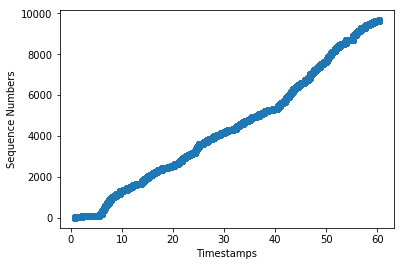

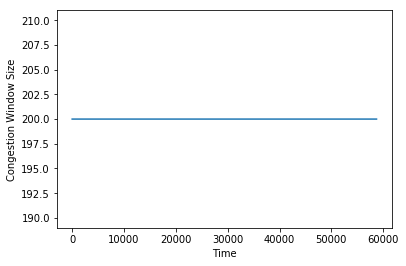

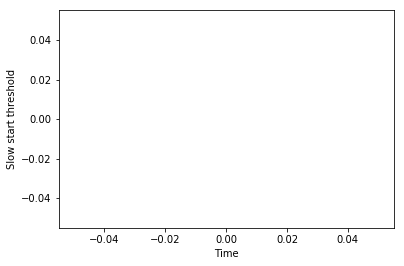

In [3]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, FixedWindowStrategy(200))])

# Congestion Control with Tahoe

-- talk about the basics & how this is based around adjusting the congestion window.

TCP Tahoe is one of the first congestion control algorithms implemented. A rough sketch of its implementation is that it has two phases, slow start and congestion avoidance.

In the slow start phase, t